<h2>Facial Mask Detection with Convolution Neural Network (CNN) based on Tensorflow</h2>

You will learn how to train a deep neural network for object detection in images using <a href="https://cs231n.github.io/transfer-learning/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01">transfer learning</a> with <a href="https://www.tensorflow.org/lite/examples/object_detection/overview?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01">a Mobilenet model</a>.

## Import Libraries and Define Auxiliary Functions


Import libraries:


In [6]:
%%capture

import os

import random
import numpy as np
import matplotlib.pyplot as plt

import six.moves.urllib as urllib
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img


ModuleNotFoundError: No module named 'sklearn'

## Loading the dataset

In [4]:
# Mask and WithoutMask folders path

mask_path = "/Users/cauaveiga/Documents/Coding/Coursera AI Engineering/Mask Classifier/data/with_mask"
mask_names = os.listdir(repr(mask_path)[1:-1])
w_mask_path = "/Users/cauaveiga/Documents/Coding/Coursera AI Engineering/Mask Classifier/data/without_mask"
w_mask_names = os.listdir(repr(w_mask_path)[1:-1])

# Now we create a dictionary containing the image path and it's respective label
dataset = {}

for mask in mask_names:
   # mask image path
    mip = mask_path +"/"+ mask
    # append the mask image path with the associated label
    dataset[mip] = "Mask"
    
    
for w_mask in w_mask_names:    
    # whitout mask image path
    wmip = w_mask_path +"/"+ w_mask
    # append the no mask image path with the associated label
    dataset[wmip] = "No Mask"
    

# The next step is to shuffle this dictionary, so that we can proper split into trainning and validation data
shuffled_dataset = list(dataset.items())
random.shuffle(shuffled_dataset)

# shuffled_dataset returns a list of tuples, each tuple containing a path to a image an its respective label
# for example:
shuffled_dataset[56]


('/Users/cauaveiga/Documents/Coding/Coursera AI Engineering/Mask Classifier/data/with_mask/460-with-mask.jpg',
 'Mask')

## Preprocessing and split

In [12]:
# Now we will create our tranning data, trainning label, validation data and validation label

# First of all we define the empty lists;
X_train = []
y_train = []
X_test =[]
y_test = []

# We will split the data set as follows: 70% Trainning data; 30% Validation data
split_in = int(len(shuffled_dataset)*70/100)

# trainning set:
for impath in shuffled_dataset[:split_in]:
    #impath[0]: path; impath[1]:label
    # load the input image (224x224) and preprocess it
    image = load_img(impath[0], target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    X_train.append(image)
    y_train.append(impath[1])
    
# validation set:
for impath in shuffled_dataset[split_in:]:
    #impath[0]: path; impath[1]:label
    # load the input image (224x224) and preprocess it
    image = load_img(impath[0], target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    X_test.append(image)
    y_test.append(impath[1])    

# and we can check if we have the desired size:
print(f"Trainning_data = {round(len(X_train)*100/len(shuffled_dataset),2)}%\nValidation_data={round(len(X_test)*100/len(shuffled_dataset),2)}%")

# We now convert everything to numpy arrays:
X_train = np.array(X_train, dtype="float32")
y_train = np.array(y_train)
X_test = np.array(X_test, dtype="float32")
y_test = np.array(y_test)

Trainning_data = 69.99%
Validation_data=30.01%


As we have a relative small dataset, we will perform data augmentation techniques in order to improve our model performance, by creating "new images" from the existing one, for example a flipped dataset.

In [13]:
# Transform our labels using OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1,1))
y_test = encoder.transform(y_test.reshape(-1,1))


# Following we will define our image generator for the tranning data augmentation 
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.3,
    zoom_range=0.15,
    fill_mode="nearest")
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

## Selecting the Model

### MobileNetV2

You will upload your object detection model configuration which is MobileNetV2 from tensorflow.org. There are also many other object detection models available. If you are interested go to this link (<https://github.com/tensorflow/models/blob/7c2ff1afc4423266223bcd50cba0ed55aca826c8/research/object_detection/g3doc/tf1_detection_zoo.md>) and you will find many other models. Training a model from scratch can take long hours and tons of data. So, we helped you in reducing that effort by training the MobileNet model with a checkpoint.

In [7]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False


2021-09-28 20:40:30.605919: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Start Training



In [15]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 40
BS = 32

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    datagen.flow(X_train, y_train.toarray(), batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test.toarray()),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


2021-09-28 20:43:36.554477: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/40
30/30 [==============================] - 23s 729ms/step - loss: 0.7457 - accuracy: 0.6112 - val_loss: 0.3219 - val_accuracy: 0.9734
Epoch 2/40
30/30 [==============================] - 22s 721ms/step - loss: 0.3483 - accuracy: 0.9265 - val_loss: 0.1728 - val_accuracy: 0.9855
Epoch 3/40
30/30 [==============================] - 23s 769ms/step - loss: 0.2294 - accuracy: 0.9468 - val_loss: 0.1101 - val_accuracy: 0.9903
Epoch 4/40
30/30 [==============================] - 24s 795ms/step - loss: 0.1436 - accuracy: 0.9909 - val_loss: 0.0758 - val_accuracy: 0.9903
Epoch 5/40
30/30 [==============================] - 24s 810ms/step - loss: 0.1115 - accuracy: 0.9892 - val_loss: 0.0587 - val_accuracy: 0.9903
Epoch 6/40
30/30 [==============================] - 26s 864ms/step - loss: 0.0923 - accuracy: 0.9749 - val_loss: 0.0501 - val_accuracy: 0.9927
Epoch 7/40
30/30 [==============================] - 26s 860ms/step - loss: 0.0879 - accuracy: 0.9862 - val_loss: 0.0422 - val_accuracy: 0.9927

[INFO] evaluating network...
              precision    recall  f1-score   support

        Mask       1.00      0.99      0.99       212
     No Mask       0.99      1.00      0.99       201

    accuracy                           0.99       413
   macro avg       0.99      0.99      0.99       413
weighted avg       0.99      0.99      0.99       413



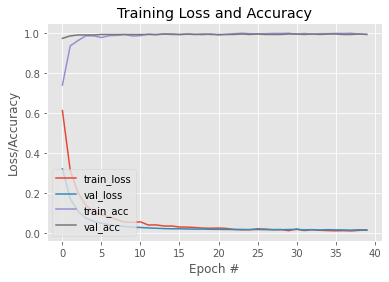

In [24]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(y_test.toarray().argmax(axis=1), predIdxs,target_names=["Mask","No Mask"]))


# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [26]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
#model.save(args["model"], save_format="h5")

# Save the entire model as a SavedModel.
#!mkdir -p saved_model
model.save('mask_detector_model')

[INFO] saving mask detector model...


## Let's Test the Model and See How Cool It Is!


We are going to use the image saved in this notebook. You can also add your own image by providing a URL.

(Here we are making all the necessary imports to that step again, so that you can run it whenever you want, without the need of running any other cell in this notebook! Feel free to use whatever image you want to. Just make sure to pass the right path to load the model)


2021-10-18 01:23:05.043937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


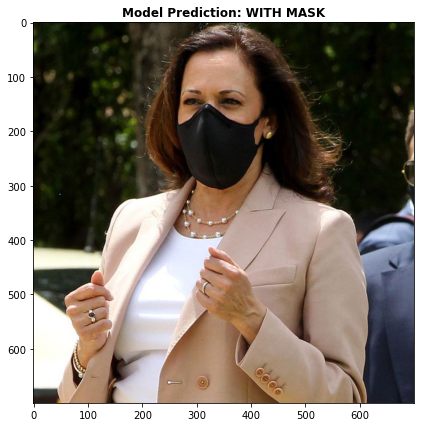

In [10]:
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import six.moves.urllib as urllib

# Here you can specify your own image 
URL = 'https://cdn.cliqueinc.com/posts/289533/kamala-harris-face-mask-289533-1602269219518-square.700x0c.jpg' 

with urllib.request.urlopen(URL) as url:
    with open('test.jpg', 'wb') as f:
        f.write(url.read())
        
image_ = Image.open('test.jpg')
image = image_.copy()

# Load the mask detection model
mask_model = load_model('mask_detector_model')

image = img_to_array(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
#image = img_to_array(image)
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)

# Make the prediction (return the probability of mask or no_mask)
(mask,no_mask) = mask_model.predict(image)[0]

title = "Model Prediction: " + ( "WITH MASK" if np.argmax((mask,no_mask)) == 0 else "WITHOUT MASK")

plt.figure(figsize=(14,7))
plt.imshow(image_)
plt.title(title,fontweight="bold")
plt.show()